# 代码1

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible
np.random.seed(1)

# 超参数
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

In [2]:
def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    paintings = torch.from_numpy(paintings).float()
    return paintings

In [3]:
G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS, 128),            # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS, 128),     # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

In [4]:
for step in range(10000):
    artist_paintings = artist_works()           # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)    # random ideas
    G_paintings = G(G_ideas())                  # fake painting from G (random ideas)

    prob_artist0 = D(artist_paintings)          # D try to increase this prob
    prob_artist1 = D(G_paintings)               # D try to reduce this prob

TypeError: 'Tensor' object is not callable

In [ ]:
D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
G_loss = torch.mean(torch.log(1. - prob_artist1))

In [5]:
opt_D.zero_grad()
D_loss.backward(retain_graph=True)      # retain_graph 这个参数是为了再次使用计算图纸
opt_D.step()

opt_G.zero_grad()
G_loss.backward()
opt_G.step()

NameError: name 'opt_D' is not defined

# 代码2

In [ ]:
# 实现简单的DCGAN(深度卷积生成对抗网络)
from keras.layers import Conv2D, Dense, Flatten, LeakyReLU, Reshape, Conv2DTranspose, \
    BatchNormalization, Input, Dropout
from keras.models import Sequential, Model, load_model
from keras.optimizers import adam
from keras.utils import plot_model
import numpy as np
from keras.datasets import  mnist
from keras.utils import np_utils


def uniform_sampling(n_sample, dim):
    # 均匀分布采样
    return np.random.uniform(0, 1, size=(n_sample, dim))


def normal_sampling(n_sample, dim):
    # 均匀分布采样
    return np.random.randn(n_sample, dim)


# 构建判别网络
d_model = Sequential()
d_model.add(BatchNormalization())
d_model.add(Dropout(0.3))
d_model.add(Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
d_model.add(LeakyReLU(0.2))
d_model.add(Dropout(0.3))
d_model.add(Conv2D(128, (3, 3), strides=2, padding='same'))  # 用带步长卷积层替代池化层
d_model.add(LeakyReLU(0.2))
d_model.add(Dropout(0.3))
d_model.add(Conv2D(256, (3, 3), padding='same'))
d_model.add(LeakyReLU(0.2))
d_model.add(Dropout(0.3))
d_model.add(Conv2D(512, (3, 3), strides=2, padding='same'))
d_model.add(LeakyReLU(0.2))
d_model.add(Flatten())
d_model.add(Dropout(0.3))
d_model.add(Dense(1, activation='sigmoid'))  # 输出样本标记为1，即假样本的概率

# 构建生成网络
g_model = Sequential()
g_model.add(BatchNormalization())
g_model.add(Dense(7 * 7 * 256, activation='relu', input_dim=100))
g_model.add(Reshape((7, 7, 256)))
g_model.add(BatchNormalization())
g_model.add(Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'))  # 反卷积
g_model.add(BatchNormalization())
g_model.add(Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'))
g_model.add(BatchNormalization())
g_model.add(Conv2DTranspose(32, 3, strides=1, padding='same', activation='relu'))
g_model.add(BatchNormalization())
g_model.add(Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh'))


class DCGAN:
    def __init__(self, d_model, g_model,
                 input_dim=784, g_dim=100,
                 max_step=100, sample_size=256, d_iter=3, kind='normal'):
        self.input_dim = input_dim  # 图像的展开维度，即判别网络的输入维度
        self.g_dim = g_dim  # 随机噪声维度，即生成网络的输入维度
        self.max_step = max_step  # 整个模型的迭代次数
        self.sample_size = sample_size  # 训练过程中小批量采样的个数的一半
        self.d_iter = d_iter  # 每次迭代，判别网络训练的次数
        self.kind = kind  # 随机噪声分布类型

        self.d_model = d_model  # 判别模型
        self.g_model = g_model  # 生成模型
        self.m_model = self.merge_model()  # 合并模型

        self.optimizer = adam(lr=0.0002, beta_1=0.5)
        self.d_model.compile(optimizer=self.optimizer, loss='binary_crossentropy')

    def merge_model(self):
        # 合并生成网络与判别网络
        noise = Input(shape=(self.g_dim,))
        gen_sample = self.g_model(noise)
        self.d_model.trainable = False  # 固定判别网络，训练合并网络等同与训练生成网络
        d_output = self.d_model(gen_sample)
        m_model = Model(noise, d_output)  # 模型输出生成样本的预测结果，越接近0越好
        m_model.compile(optimizer='adam', loss='binary_crossentropy')
        return m_model

    def gen_noise(self, num_sample):
        # 生成随机噪声数据
        if self.kind == 'normal':
            f = normal_sampling
        elif self.kind == 'uniform':
            f = uniform_sampling
        else:
            raise ValueError('暂不支持分布{}'.format(self.kind))
        return f(num_sample, self.g_dim)

    def gen_real_data(self, train_data):
        # 真实样本采样
        n_samples = train_data.shape[0]
        inds = np.random.randint(0, n_samples, size=self.sample_size)
        real_data = train_data[inds]
        real_label = np.random.uniform(0, 0.3,
                                       size=(self.sample_size,))  # 用0-0.3随机数代替标记0
        return real_data, real_label

    def gen_fake_data(self):
        # 生成样本
        noise = self.gen_noise(self.sample_size)
        fake_data = g_model.predict(noise)  # 生成网络生成M个样本，标记为0
        fake_label = np.random.uniform(0.7, 1.2,
                                       size=(self.sample_size,))  # 用0.7-1.2随机数代替标记1
        return fake_data, fake_label

    def fit(self, train_data):
        # 轮流训练判别网络和生成网络
        for i in range(self.max_step):
            for _ in range(self.d_iter):  # 训练判别网络
                real_data, real_label = self.gen_real_data(train_data)
                d_model.train_on_batch(real_data, real_label)
                fake_data, fake_label = self.gen_fake_data()
                d_model.train_on_batch(fake_data, fake_label)
            # 训练生成网络
            noise = self.gen_noise(self.sample_size)
            expected_label = np.random.uniform(0, 0.3, size=(self.sample_size,))  # 期望输出0
            self.d_model.trainable = False
            self.m_model.compile(optimizer=self.optimizer, loss='binary_crossentropy')
            gan_loss = self.m_model.train_on_batch(noise, expected_label)
            print('第{0}次迭代训练损失值:{1:.3f}'.format(i + 1, gan_loss))
        return

    def gen_samples(self, num):
        # 生成网络生成数据
        z = self.gen_noise(num)
        imgs = g_model.predict(z)
        return imgs

    def save_model(self):
        # 保存训练后的模型
        self.d_model.save('d_model.hdf5')
        self.g_model.save('g_model.hdf5')
        return


if __name__ == '__main__':
    # d_model = load_model('D:\Machine_Learning\deep_learning_algorithm\gan\d_model.hdf5')
    # g_model = load_model('D:\Machine_Learning\deep_learning_algorithm\gan\g_model.hdf5')
    # plot_model(d_model, 'd_model.png')
    # plot_model(g_model, 'g_model.png')
    model = DCGAN(d_model, g_model, max_step=10, sample_size=1000, d_iter=2)

    # 导入数据
    input_dim = 28 * 28 * 1  # 单通道28像素的图像
    #f = mnist.load_data()
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1,1,28,28)  # normalize
    x_test = x_test.reshape(-1,1,28,28)    # normalize
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    
    x_train = np.reshape(x_train, [-1, input_dim])
    x_train = (x_train.astype('float32') - 127.5) / 127.5  # 规范化到(-1,1)
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))  # 转换成卷积网络层标准的数据格式
    # 训练
    model.fit(x_train)
    model.save_model()
    # 生成样本并可视化
    imgs = model.gen_samples(10)


    def plot_img(gen_imgs):
        # 对比重构前后的图像
        import matplotlib.pyplot as plt

        n = 10
        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(gen_imgs[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        return


    plot_img(imgs)

# 代码3

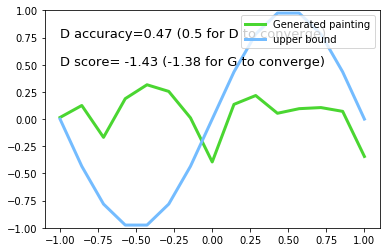

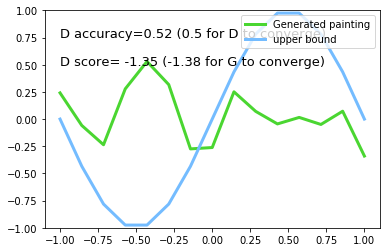

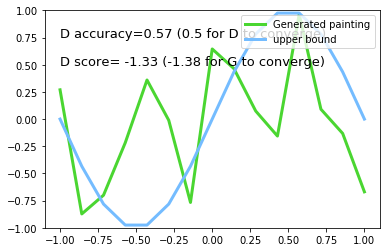

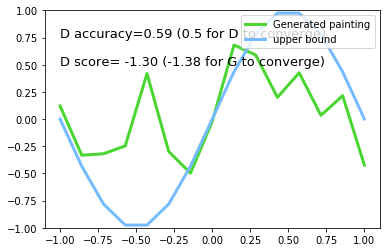

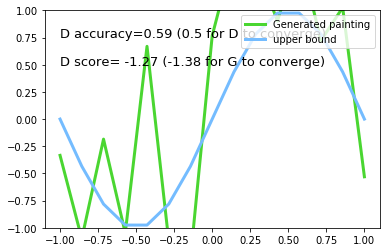

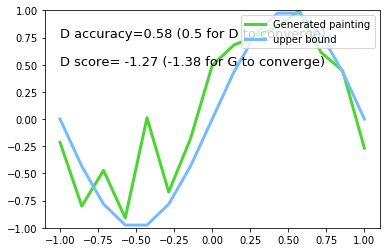

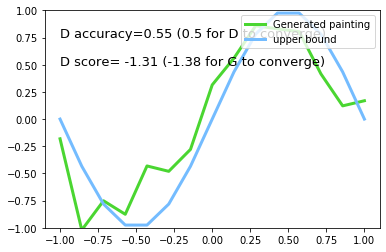

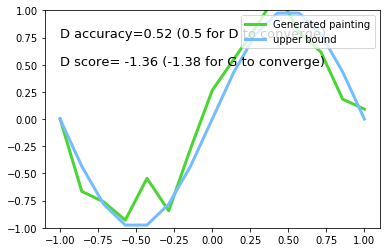

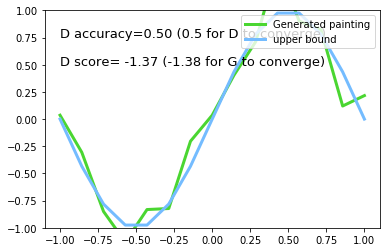

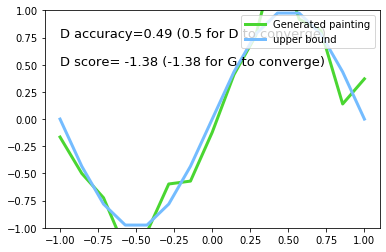

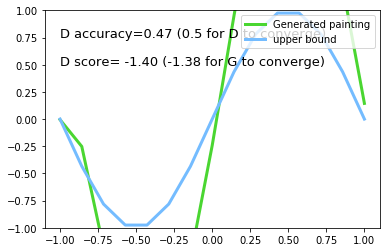

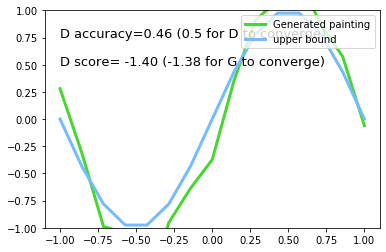

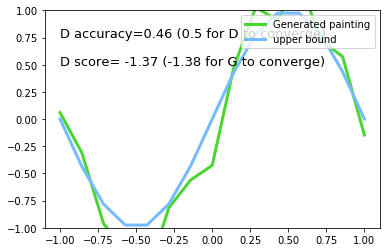

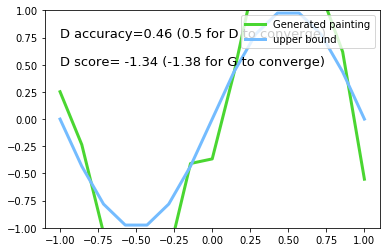

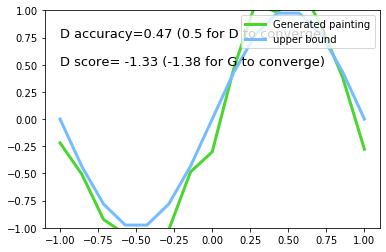

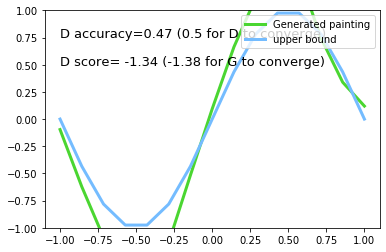

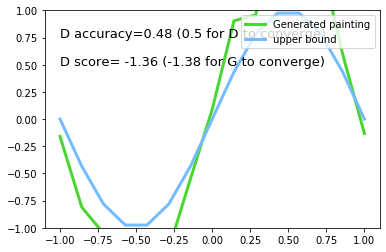

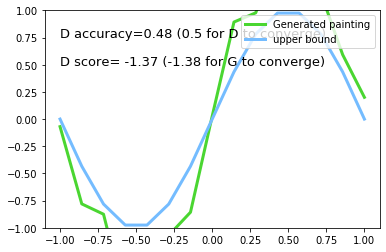

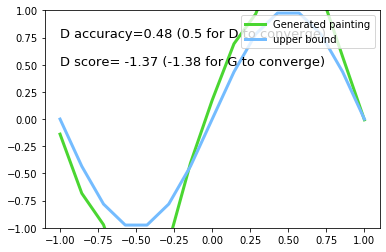

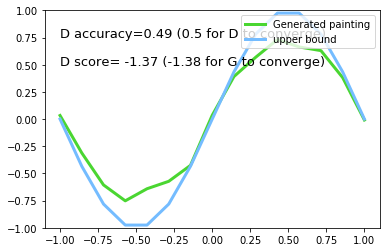

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)       # reproducible
# np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001       # learning rate for generator
LR_D = 0.0001       # learning rate for discriminator
N_IDEAS = 5         # think of this as number of ideas for generating an art work(Generator)
ART_COMPONENTS = 15 # it could be total point G can drew in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])


def artist_works():    # painting from the famous artist (real target)
    #a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    r = 0.02 * np.random.randn(1, ART_COMPONENTS)
    paintings = np.sin(PAINT_POINTS * np.pi) + r
    paintings = torch.from_numpy(paintings).float()
    return paintings


G = nn.Sequential(                  # Generator
    nn.Linear(N_IDEAS, 128),        # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS), # making a painting from these random ideas
)

D = nn.Sequential(                  # Discriminator
    nn.Linear(ART_COMPONENTS, 128), # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                   # tell the probability that the art work is made by artist
)


opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

plt.ion()    # something about continuous plotting

D_loss_history = []
G_loss_history = []
for step in range(1000):
    artist_paintings = artist_works()          # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS) # random ideas
    G_paintings = G(G_ideas)                   # fake painting from G (random ideas)
    
    prob_artist0 = D(artist_paintings)         # D try to increase this prob
    prob_artist1 = D(G_paintings)              # D try to reduce this prob
    
    D_loss = - torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
    G_loss = torch.mean(torch.log(1. - prob_artist1))
    
    D_loss_history.append(D_loss)
    G_loss_history.append(G_loss)
    
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)    # reusing computational graph
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], np.sin(PAINT_POINTS[0] * np.pi), c='#74BCFF', lw=3, label='upper bound')
        plt.text(-1, 0.75, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-1, 0.5, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.ylim((-1, 1));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.01)

plt.ioff()
plt.show()